#### Draw ground truth correlation across ROI and attention condition

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.express as px
from plot_utils import plotly_template

# stats
from scipy.stats import permutation_test
def statistic(condA, condB, axis):
    return np.nanmean(condA, axis=axis) - np.nanmean(condB, axis=axis)
n_permutation = 10000

def get_pval(perm_res):
    p_val_unilateral = perm_res.pvalue/2
    p_val_bilateral = perm_res.pvalue

    if p_val_unilateral > 0.05: p_text_unilateral = 'p = {:1.2f}'.format(p_val_unilateral)
    if p_val_unilateral < 0.05: p_text_unilateral = 'p < 0.05'
    if p_val_unilateral < 0.01: p_text_unilateral = 'p < 0.01'
    if p_val_unilateral < 0.001: p_text_unilateral = 'p < 0.001'
    if p_val_unilateral < 0.0001: p_text_unilateral = 'p < 0.0001'

    if p_val_bilateral > 0.05: p_text_bilateral = 'p = {:1.2f}'.format(p_val_bilateral)
    if p_val_bilateral < 0.05: p_text_bilateral = 'p < 0.05'
    if p_val_bilateral < 0.01: p_text_bilateral = 'p < 0.01'
    if p_val_bilateral < 0.001: p_text_bilateral = 'p < 0.001'
    if p_val_bilateral < 0.0001: p_text_bilateral = 'p < 0.0001'
    
    return (p_val_unilateral, p_text_unilateral, p_val_bilateral, p_text_bilateral)
    
# Define parameters
subjects = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
            'sub-005', 'sub-006', 'sub-007', 'sub-008']
subjects_plot = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
                 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'group']
rois = ['V1', 'V2', 'V3', 'V3AB', 'hMT+', 'LO',
        'VO', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)
group_tsv_dir = '{}/{}/decode/tsv'.format(pp_dir, 'group')


# General figure settings
template_specs = dict(  axes_color="rgba(0, 0, 0, 1)",
                        axes_width=2,
                        axes_font_size=13,
                        bg_col="rgba(255, 255, 255, 1)",
                        font='Arial',
                        title_font_size=15,
                        plot_width=1.5)
fig_template = plotly_template(template_specs)

In [ ]:
# load TSV
df_all_fn = "{}/predictive_accuracy_n_voxels-250.tsv".format(group_tsv_dir)
df_all = pd.read_csv(df_all_fn, sep="\t")
for subject_num, subject in enumerate(subjects):

    df_new = pd.DataFrame({'subject': [subject]*len(rois)}) 
    df_new['roi'] = rois
    df_new['ab_ground_truth_cor'] = np.array(df_all.loc[(df_all.subject==subject_num+1) & (df_all.task=='attend-bar')].gardner)
    df_new['af_ground_truth_cor'] = np.array(df_all.loc[(df_all.subject==subject_num+1) & (df_all.task=='attend-fix')].gardner)
    
    if subject_num > 0: df = pd.concat([df,df_new], ignore_index=True)
    else: df = df_new
df.roi = pd.Categorical(df.roi,categories=rois)

df_fn = "{}/group_ground_truth_cor_best250.tsv".format(group_tsv_dir)
print('saving {}'.format(df_fn))
df.to_csv(df_fn, sep="\t", na_rep='NaN')

# Compute permutation statistics results
for roi_num, roi in enumerate(rois):
    # get values
    ab_ground_truth_cor_array = df.loc[(df.roi == roi)].groupby(['subject']).ab_ground_truth_cor.mean()
    af_ground_truth_cor_array = df.loc[(df.roi == roi)].groupby(['subject']).af_ground_truth_cor.mean()
    zero_ground_truth_cor_array = np.zeros_like(ab_ground_truth_cor_array)

    # comparison af/ab
    ab_af_perm_res = permutation_test((ab_ground_truth_cor_array, af_ground_truth_cor_array), statistic, n_resamples=n_permutation, 
                                 alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
    ab_af_p_val_uni, ab_af_p_text_uni, ab_af_p_val_bi, ab_af_p_text_bi = get_pval(ab_af_perm_res)

    # comparison ab/zero
    ab_zero_perm_res = permutation_test((ab_ground_truth_cor_array, zero_ground_truth_cor_array), statistic, n_resamples=n_permutation, 
                                    alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
    ab_zero_p_val_uni, ab_zero_p_text_uni, ab_zero_p_val_bi, ab_zero_p_text_bi = get_pval(ab_zero_perm_res)

    # comparison af/zero
    af_zero_perm_res = permutation_test((af_ground_truth_cor_array, zero_ground_truth_cor_array), statistic, n_resamples=n_permutation, 
                                    alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
    af_zero_p_val_uni, af_zero_p_text_uni, af_zero_p_val_bi, af_zero_p_text_bi = get_pval(af_zero_perm_res)

    df_stats = pd.DataFrame({  'roi': [roi],
                               'ab_ground_truth_cor_mean': np.nanmean(ab_ground_truth_cor_array),
                               'ab_ground_truth_cor_sem': np.nanstd(ab_ground_truth_cor_array)/np.sqrt(ab_ground_truth_cor_array.shape[0]-1),  
                               'af_ground_truth_cor_mean': np.nanmean(af_ground_truth_cor_array),
                               'af_ground_truth_cor_sem': np.nanstd(af_ground_truth_cor_array)/np.sqrt(af_ground_truth_cor_array.shape[0]-1),
                               'ab_af_diff': ab_af_perm_res.statistic,
                               'ab_af_p_val_unilateral': ab_af_p_val_uni,
                               'ab_af_p_text_unilateral': ab_af_p_text_uni,
                               'ab_af_p_val_bilateral': ab_af_p_val_bi,
                               'ab_af_p_text_bilateral': ab_af_p_text_bi,
                               'ab_zero_diff': ab_zero_perm_res.statistic,
                               'ab_zero_p_val_unilateral': ab_zero_p_val_uni,
                               'ab_zero_p_text_unilateral': ab_zero_p_text_uni,
                               'ab_zero_p_val_bilateral': ab_zero_p_val_bi,
                               'ab_zero_p_text_bilateral': ab_zero_p_text_bi,
                               'af_zero_diff': af_zero_perm_res.statistic,
                               'af_zero_p_val_unilateral': af_zero_p_val_uni,
                               'af_zero_p_text_unilateral': af_zero_p_text_uni,
                               'af_zero_p_val_bilateral': af_zero_p_val_bi,
                               'af_zero_p_text_bilateral': af_zero_p_text_bi})

    # across roi
    if roi_num == 0: df_stats_roi = df_stats
    else: df_stats_roi = pd.concat([df_stats_roi, df_stats])

df_stats_roi_fn = "{}/group_ground_truth_cor_stats_best250.tsv".format(group_tsv_dir)
print('saving {}'.format(df_stats_roi_fn))
df_stats_roi.to_csv(df_stats_roi_fn, sep="\t", na_rep='NaN')

In [ ]:
# Subplot settings
margin_t, margin_b, margin_l, margin_r = 50, 100, 100 ,50
rows, cols = 1, 1

column_widths,row_heights = [1], [1]
sb_specs = [[{}]]
subplot_width, subplot_height = 300,700

fig_width, fig_height = 0, 0
for column_width in column_widths:fig_width += subplot_width*column_width
for row_height in row_heights: fig_height +=subplot_height*row_height
fig_width = fig_width + margin_l + margin_r
fig_height = fig_height + margin_t + margin_b

yaxis_range = [0.3, 12.7]
yaxis_tick = 12
yaxis_tickvals = np.flipud(np.linspace(1,12,yaxis_tick))
yaxis_ticktext = rois

ab_col = "rgba(0, 0, 0, 1)"
af_col = "rgba(157, 157, 157, 1)"

hover_temp = 'ROI: %{y}<br>' + 'Correlation: %{x:1.2f}'
y_rois = np.flipud(np.arange(0,len(rois))+1)

# Subplot settings
# load TSV
df_fn = "{}/group_ground_truth_cor_best250.tsv".format(group_tsv_dir)
df = pd.read_csv(df_fn, sep="\t")

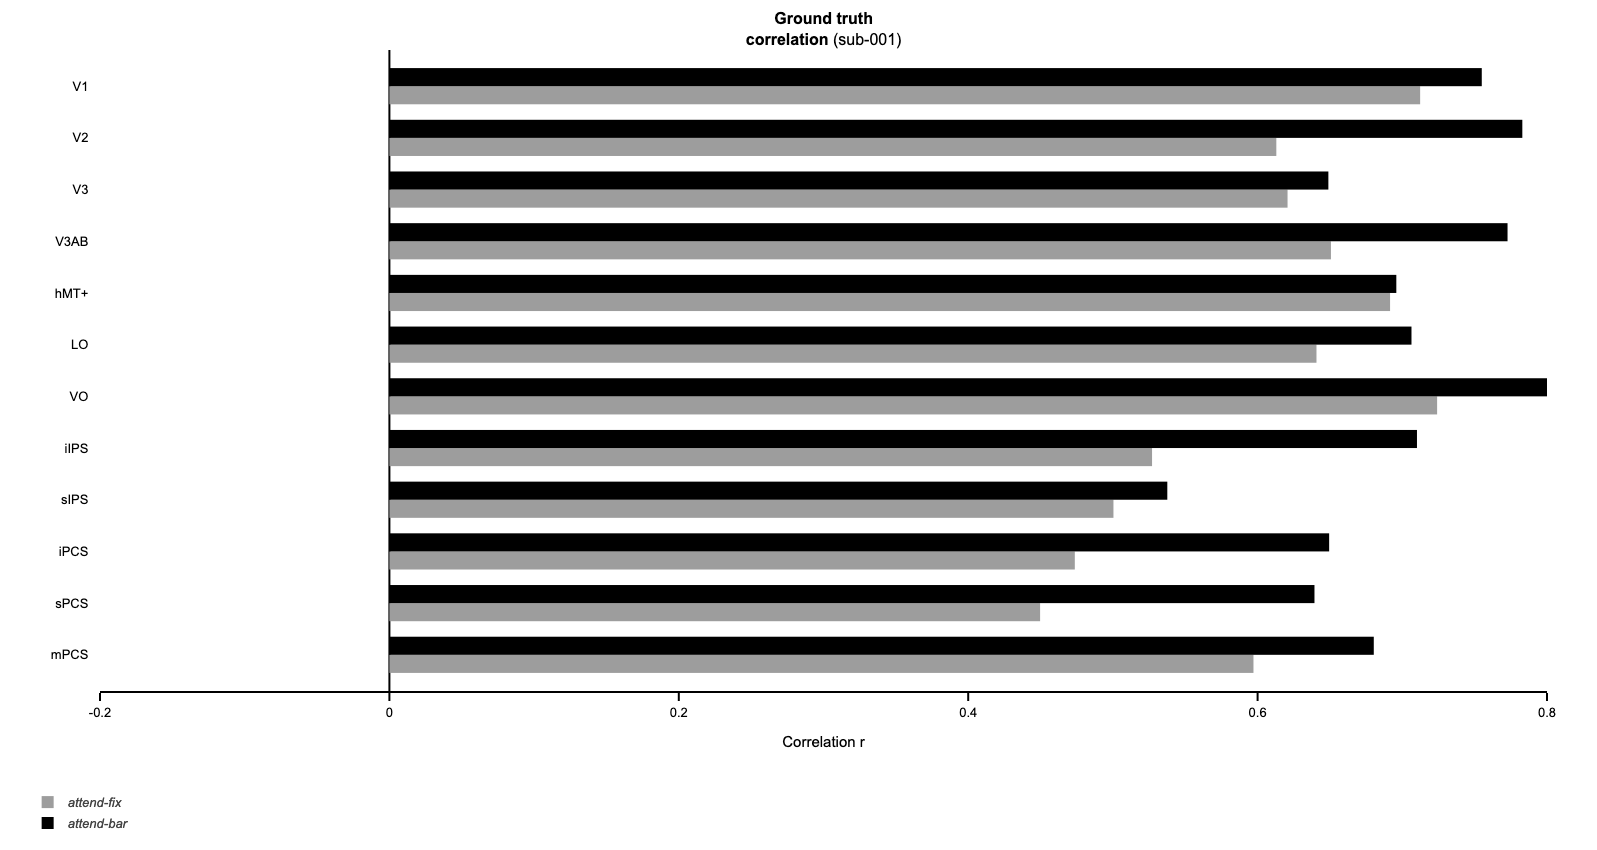

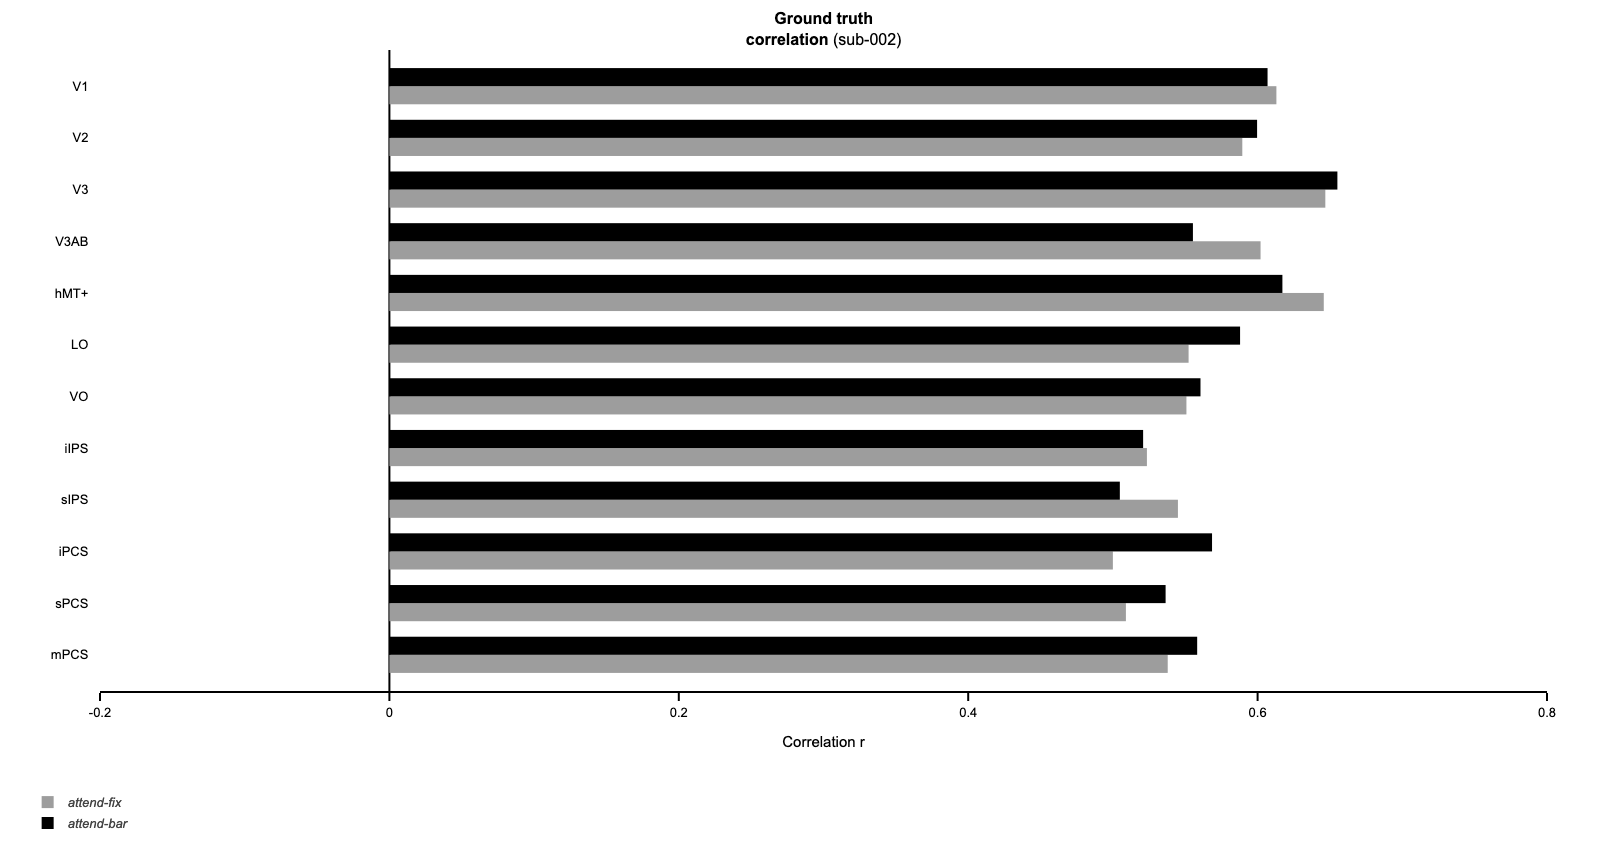

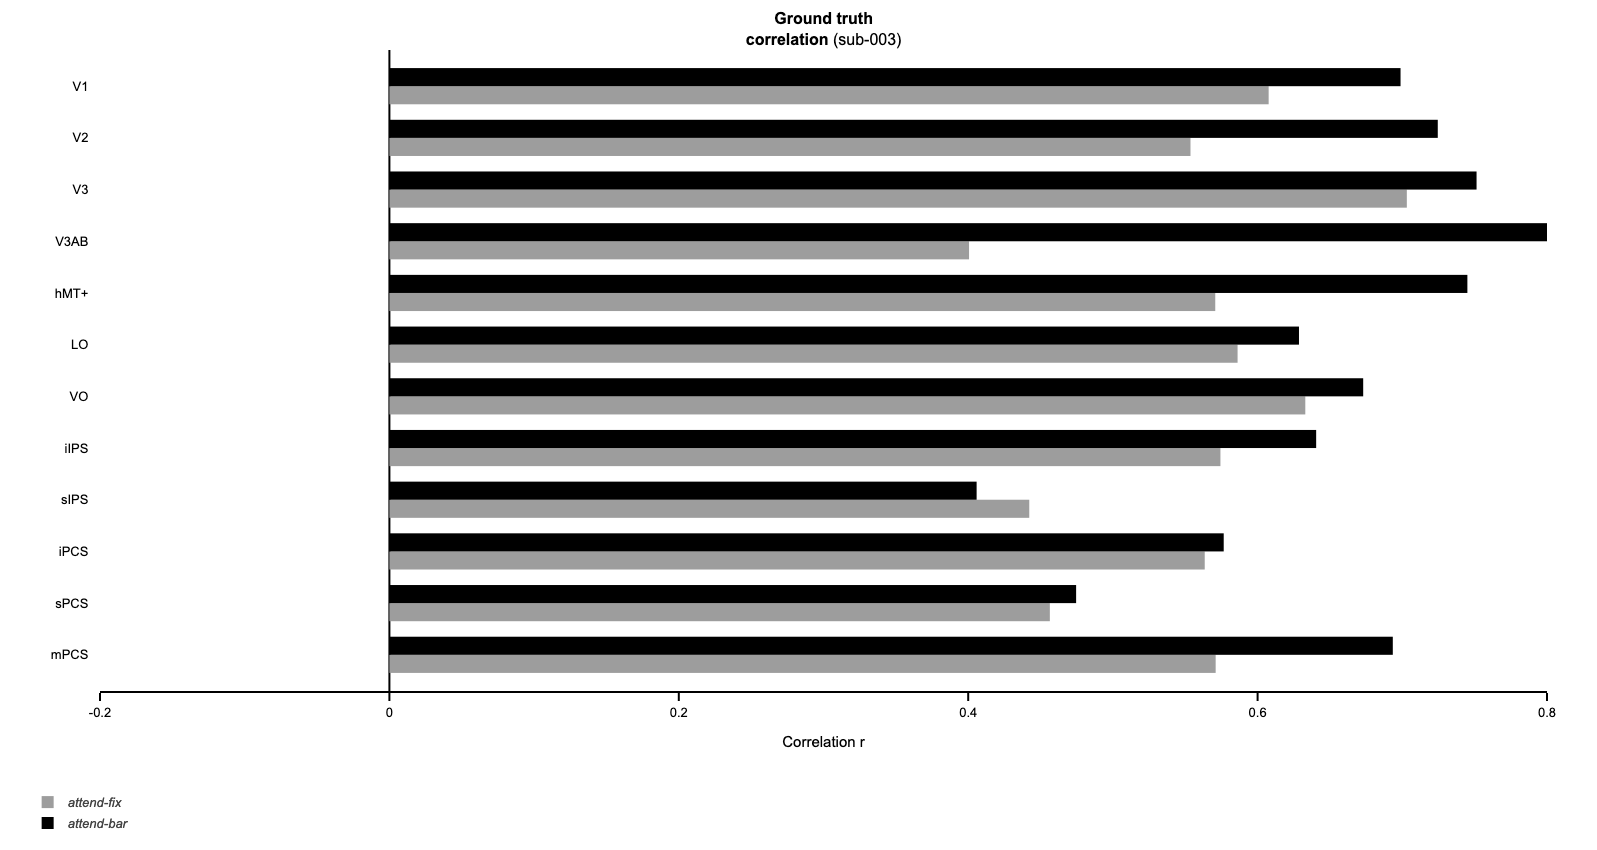

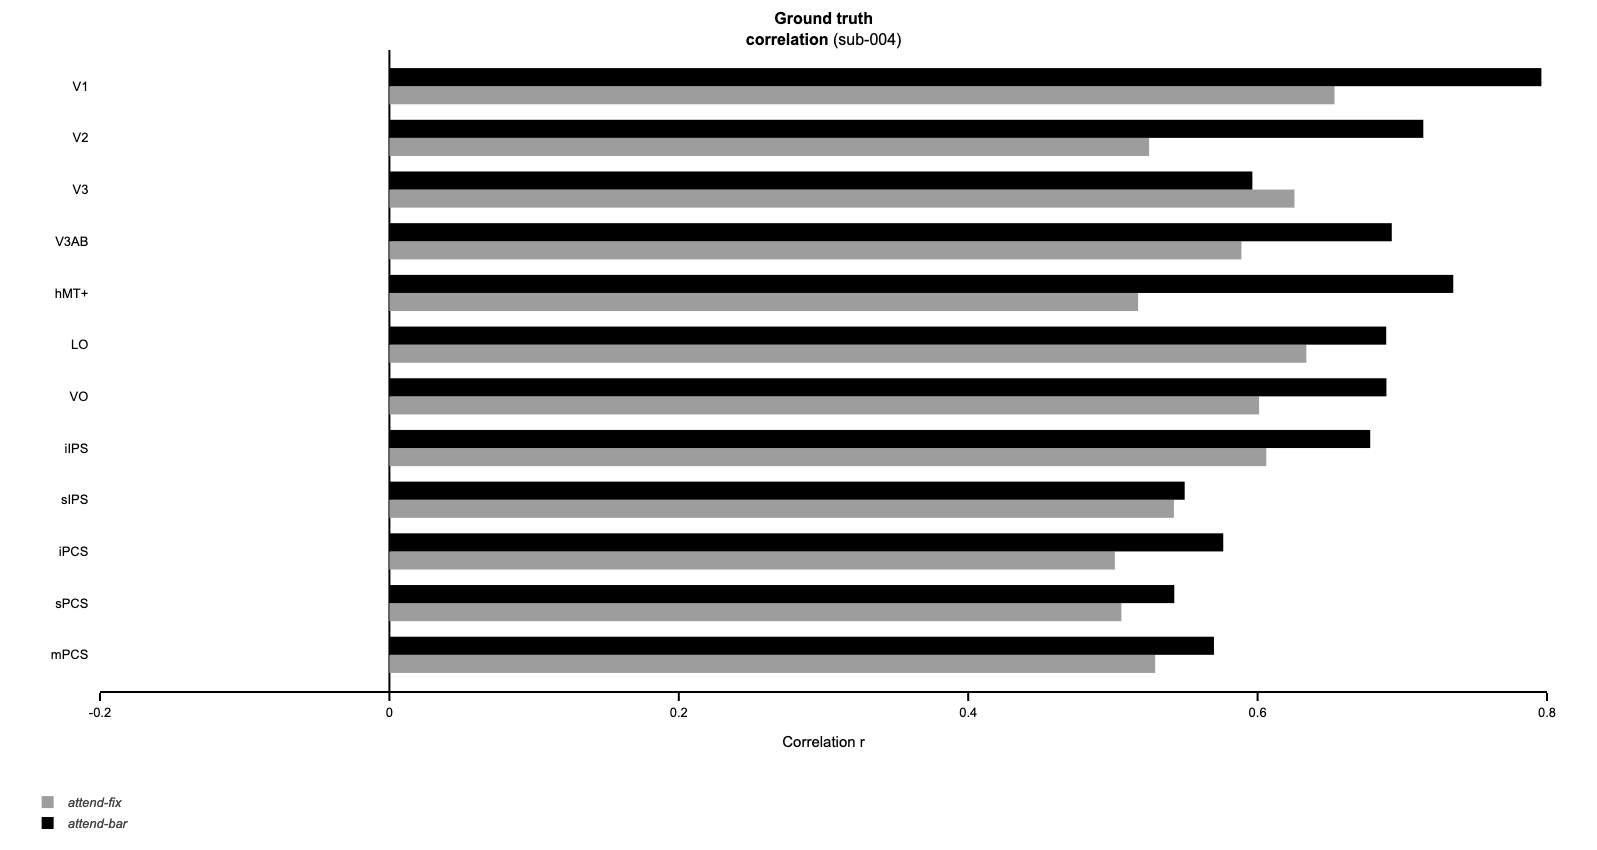

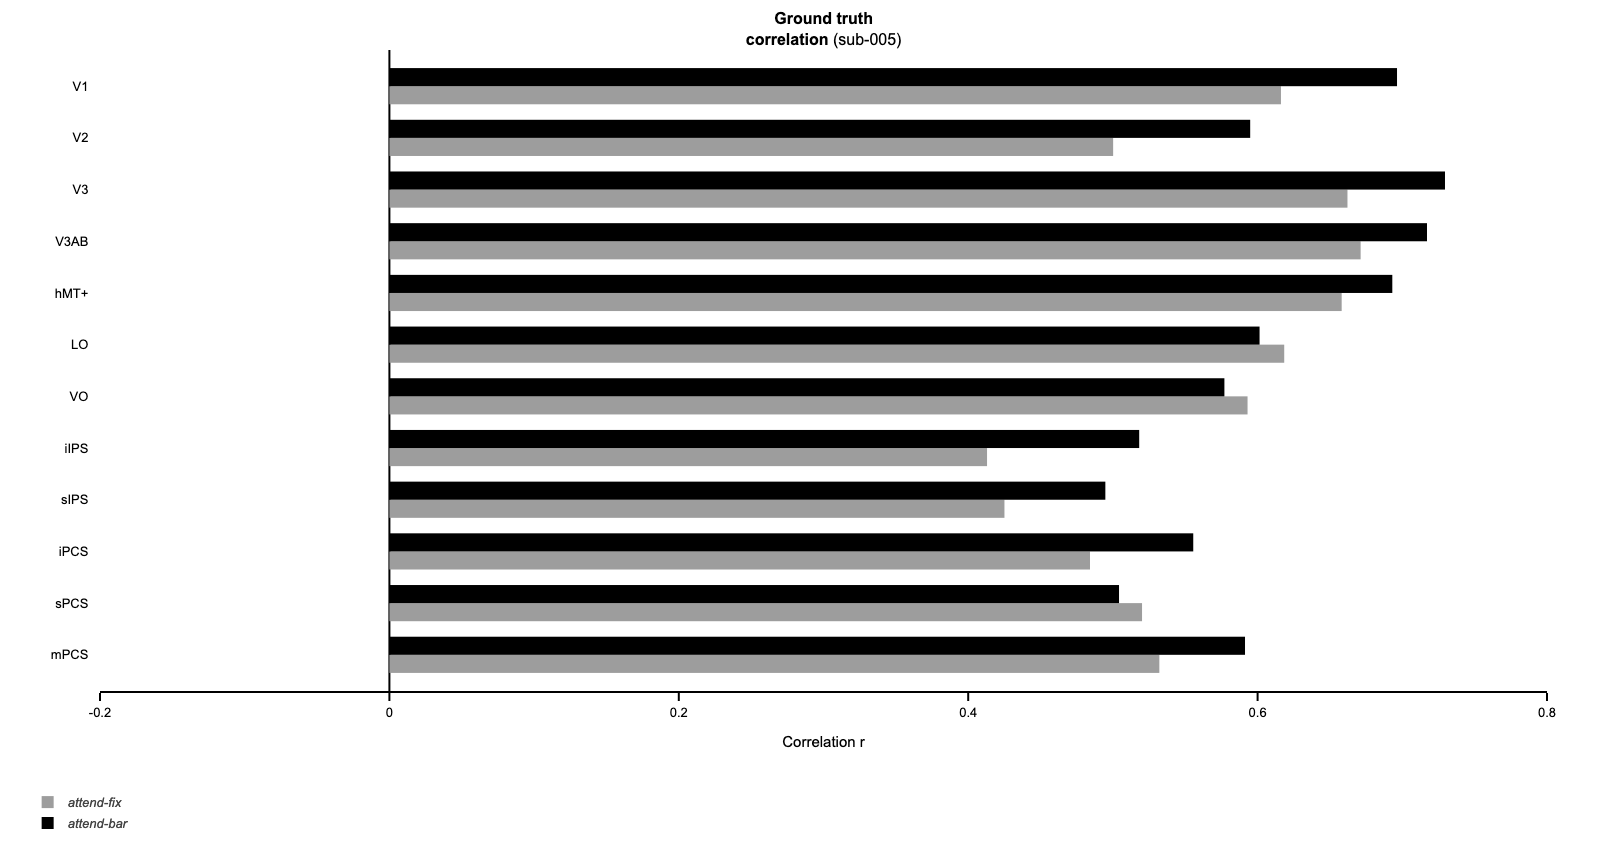

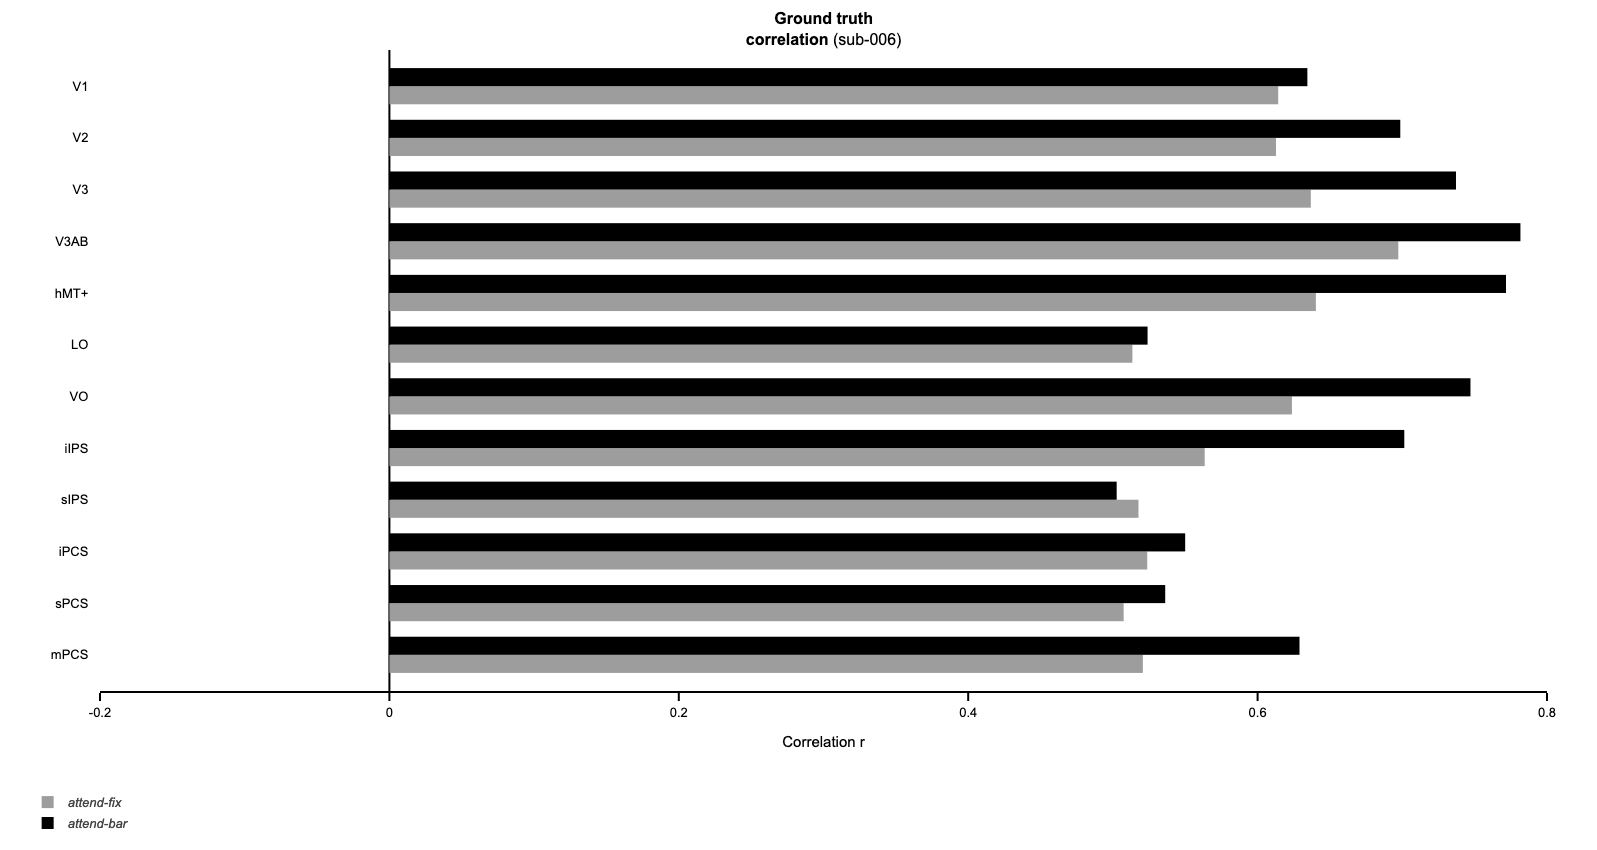

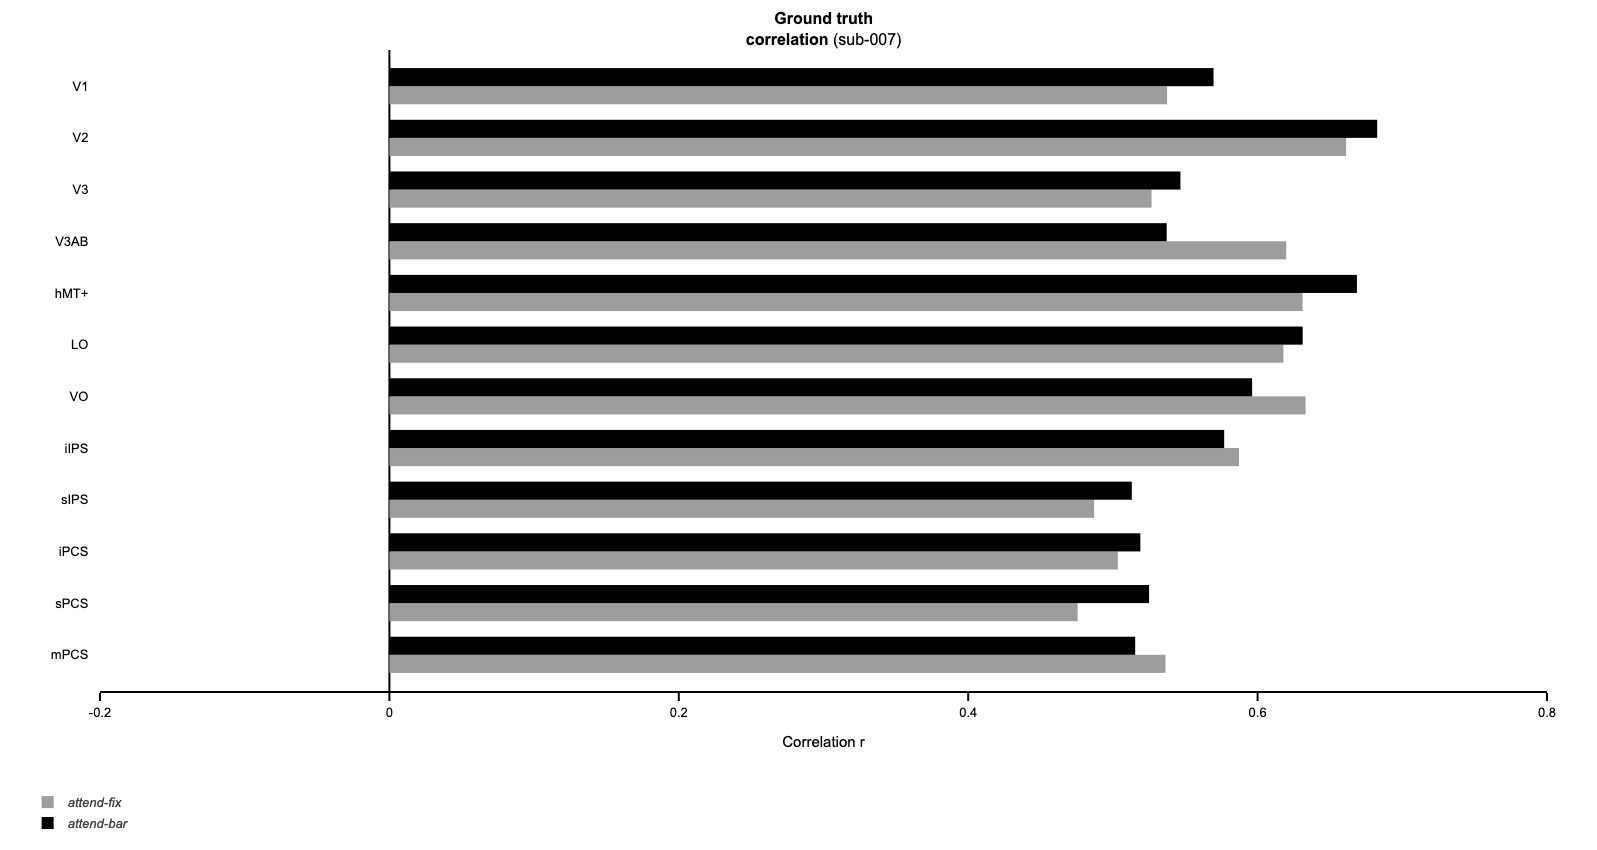

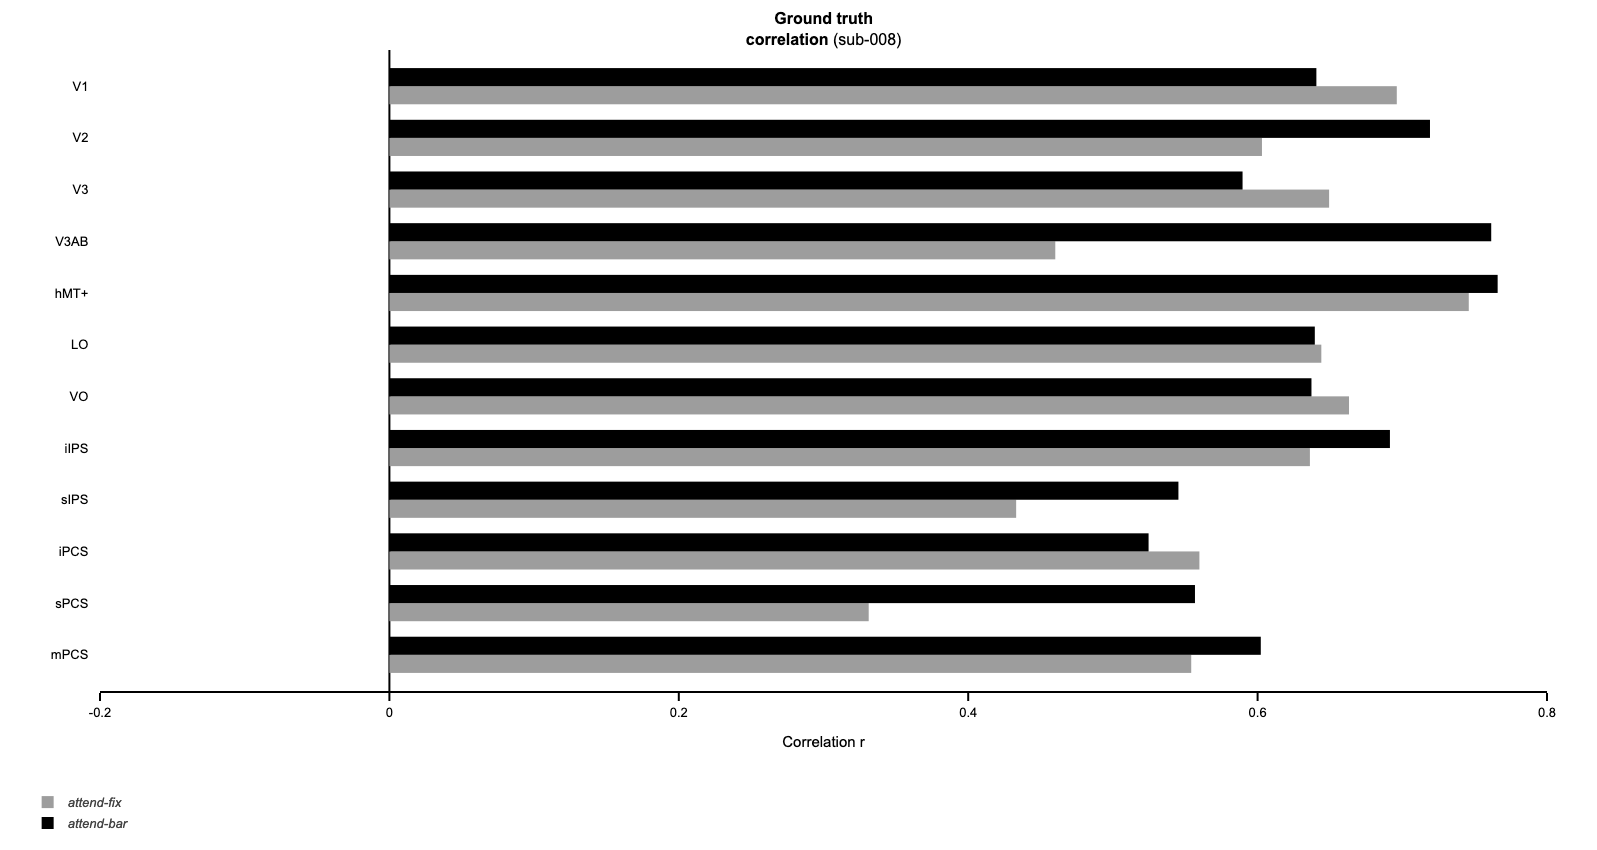

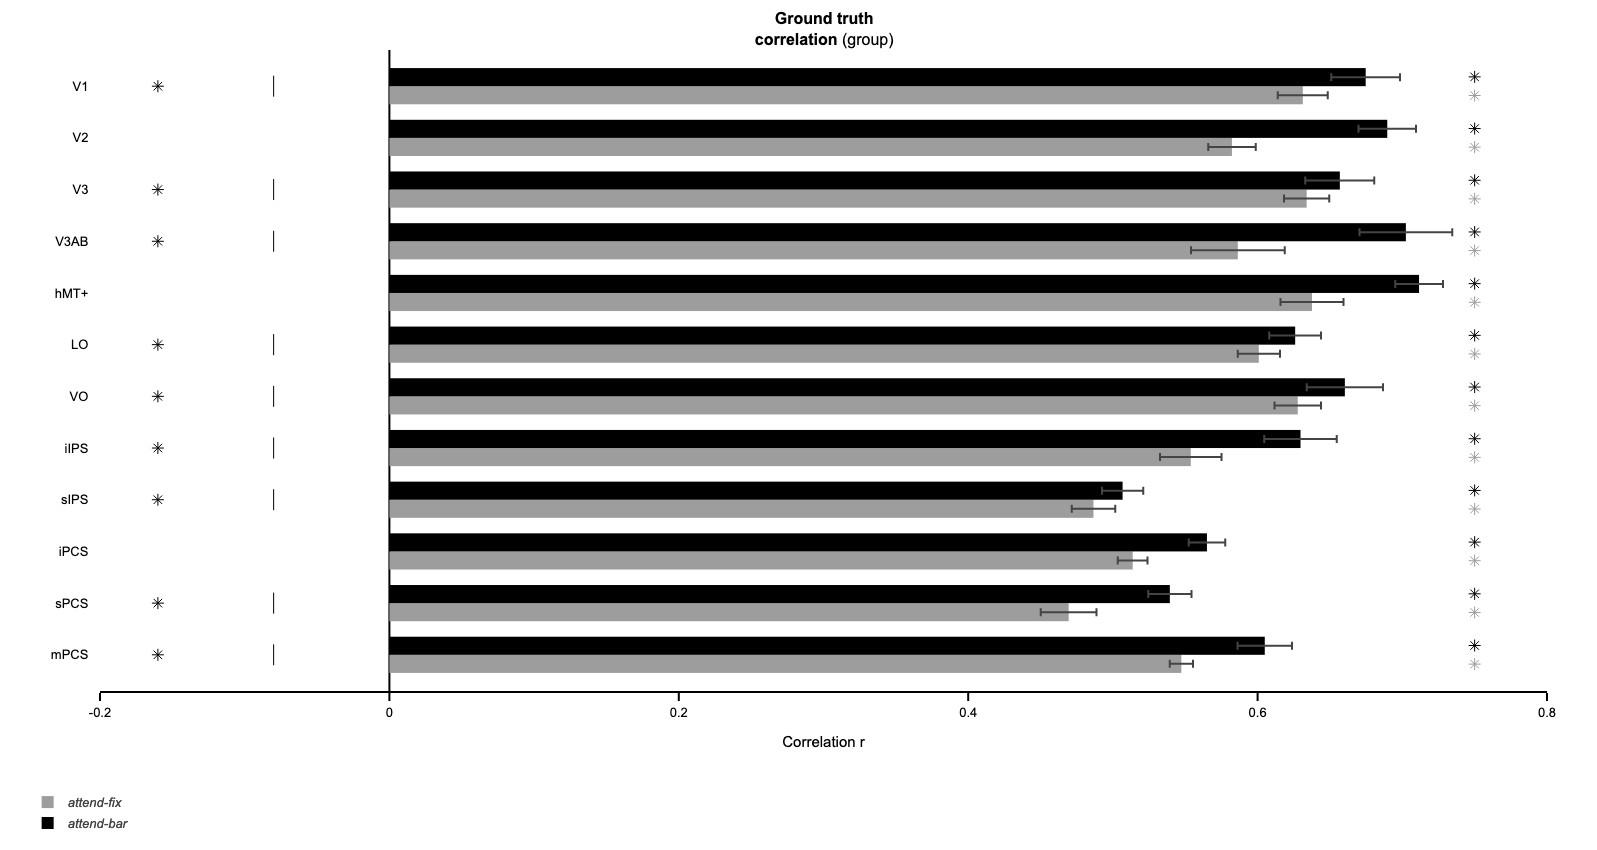

In [75]:
for subject in subjects_plot:
    if subject == 'group':
        xaxis_range = [-0.2, 0.8]
    else:
        xaxis_range = [-0.2, 0.8]

    x_gap_line = 0.1*xaxis_range[1]
    x_gap_asterisk = 0.2*xaxis_range[1]
    xaxis_tick = 6
    xaxis_tickvals = np.linspace(xaxis_range[0],xaxis_range[1],xaxis_tick)
    xaxis_title = 'Correlation r'
    xaxis_ticktext = []
    [xaxis_ticktext.append(('{:g}'.format(val))) for val in xaxis_tickvals]

    subplot_titles = ['<b>Ground truth<br>correlation</b> ({})'.format(subject)]

    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.15, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

    # get data
    if subject == 'group': 
        x_af = df.groupby(['subject','roi']).af_ground_truth_cor.mean().reset_index(name='af_ground_truth_cor_mean').groupby('roi').af_ground_truth_cor_mean.mean()
        x_ab = df.groupby(['subject','roi']).ab_ground_truth_cor.mean().reset_index(name='ab_ground_truth_cor_mean').groupby('roi').ab_ground_truth_cor_mean.mean()
        x_af_eb = df.groupby(['subject','roi']).af_ground_truth_cor.mean().reset_index(name='af_ground_truth_cor_mean').groupby('roi').af_ground_truth_cor_mean.sem(ddof=-1)
        x_ab_eb = df.groupby(['subject','roi']).ab_ground_truth_cor.mean().reset_index(name='ab_ground_truth_cor_mean').groupby('roi').ab_ground_truth_cor_mean.sem(ddof=-1)
        
        # bar plot
        fig.append_trace(go.Bar(y=y_rois, x=x_af, orientation='h', marker_color=af_col, hovertemplate=hover_temp,
                                showlegend=True, legendgroup='attend-fix', name='<i>attend-fix<i>', 
                                error_x_type='data', error_x_symmetric=False, error_x_array=x_af_eb, error_x_arrayminus=x_af_eb),row=1, col=1)

        fig.append_trace(go.Bar(y=y_rois, x=x_ab, orientation='h', marker_color=ab_col, hovertemplate=hover_temp,
                                showlegend=True, legendgroup='attend-bar', name='<i>attend-bar<i>',
                                error_x_type='data', error_x_symmetric=False, error_x_array=x_ab_eb, error_x_arrayminus=x_ab_eb),row=1, col=1)        
        
    else:
        x_af = df.loc[(df.subject==subject)].groupby('roi').af_ground_truth_cor.mean()
        x_ab = df.loc[(df.subject==subject)].groupby('roi').ab_ground_truth_cor.mean()
        
        # bar plot
        fig.append_trace(go.Bar(y=y_rois, x=x_af, orientation='h', marker_color=af_col, hovertemplate=hover_temp,
                                showlegend=True, legendgroup='attend-fix', name='<i>attend-fix<i>'),row=1, col=1)

        fig.append_trace(go.Bar(y=y_rois, x=x_ab, orientation='h', marker_color=ab_col, hovertemplate=hover_temp,
                                showlegend=True, legendgroup='attend-bar', name='<i>attend-bar<i>'),row=1, col=1)

    # get Stats 
    if subject == 'group': 

        stats_df = pd.read_csv("{}/group_ground_truth_cor_stats_best250.tsv".format(group_tsv_dir), sep="\t")

        # ab vs af
        p_flag = stats_df.ab_af_p_val_unilateral<0.05
        fig.append_trace(go.Scatter(x=np.max((x_af,x_ab),axis=0)[p_flag]*0-x_gap_line, y=y_rois[p_flag], marker_symbol='line-ns-open', 
                                    showlegend=False, mode='markers', marker_color='black', hoverinfo='skip', marker_size= 15),row=1, col=1)

        fig.append_trace(go.Scatter(x=np.max((x_af,x_ab),axis=0)[p_flag]*0-x_gap_asterisk, y=y_rois[p_flag], marker_symbol='asterisk-open',
                                    showlegend=False, mode='markers', marker_color='black', hoverinfo='skip', marker_size= 10),row=1, col=1)

        # af vs zero
        p_flag = stats_df.af_zero_p_val_unilateral<0.05
        fig.append_trace(go.Scatter(x=y_rois[p_flag]*0+0.75, y=y_rois[p_flag]-0.18, marker_symbol='asterisk-open',
                                    showlegend=False, mode='markers', marker_color=af_col, hoverinfo='skip', marker_size= 10),row=1, col=1)

        # ab vs zero
        p_flag = stats_df.ab_zero_p_val_unilateral<0.05
        fig.append_trace(go.Scatter(x=y_rois[p_flag]*0+0.75, y=y_rois[p_flag]+0.18, marker_symbol='asterisk-open',
                                    showlegend=False, mode='markers', marker_color=ab_col, hoverinfo='skip', marker_size= 10),row=1, col=1)

    # set figure axis
    for xaxis in ['xaxis']:
        exec("fig.layout.update({}_range=xaxis_range)".format(xaxis))
        exec("fig.layout.update({}_title=xaxis_title)".format(xaxis))
        exec("fig.layout.update({}_tickvals=xaxis_tickvals)".format(xaxis))
        exec("fig.layout.update({}_ticktext=xaxis_ticktext)".format(xaxis))
        exec("fig.layout.update({}_zeroline=True)".format(xaxis))

    for yaxis in ['yaxis']:
        exec("fig.layout.update({}_range=yaxis_range)".format(yaxis))
        exec("fig.layout.update({}_tickvals=yaxis_tickvals)".format(yaxis))
        exec("fig.layout.update({}_ticktext=yaxis_ticktext)".format(yaxis))

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)

    # set figure
    fig.layout.update(yaxis_title='', yaxis_color = 'rgba(0,0,0,0)', yaxis_tickfont_color='black', bargap=0.3, template=fig_template, width=fig_width, height=fig_height, margin_l=margin_l, margin_r=margin_r, margin_t=margin_t, margin_b=margin_b,
                      legend_yanchor='top', legend_y=-0.15,legend_x=-0.05, legend_xanchor='left', legend_bgcolor='rgba(255,255,255,0)', legend_tracegroupgap=1)

    # show and save figure
    tsv_dir = '{}/{}/decode/tsv'.format(pp_dir, subject)
    fig.show(config={"displayModeBar": False})
    fig.write_image("{}/{}_decode_ground_truth_cor_best250.pdf".format(tsv_dir, subject))
    fig.write_html("{}/{}_decode_ground_truth_cor_best250.html".format(tsv_dir, subject),config={"displayModeBar": False})